# MergeAdjacentImages Notebook

This notebook contains a few examples of how to use the `MergeAdjacentImages` application from **TubeTK**. First, we will include Python's `os` package as well as `ITK` (Python wrapping). We also set the TubeTK build directory variable `TUBETK_BUILD_DIR`:

We need to find the directory in which TubeTK was build. This is required to find the path to the testing data, and may be also required to find the TubeTK library paths if your python environment does not include it.
The environment variable `TubeTK_BUILD_DIR` needs to be defined.

In [1]:
import os
import sys

In [2]:
# Path for TubeTK libs
TubeTK_BUILD_DIR=None
if 'TubeTK_BUILD_DIR' in os.environ:
    TubeTK_BUILD_DIR = os.environ['TubeTK_BUILD_DIR']
if not os.path.exists(TubeTK_BUILD_DIR):
    print('TubeTK_BUILD_DIR not found!')
    print('  Set environment variable')
    sys.exit(1)

If ITK is not installed in your python environment, you need to define the environment variable `ITK_BUILD_DIR` that contains the path to where ITK was built.

In [8]:
try:
    import itk
except:
    ITK_BUILD_DIR = None
    if 'ITK_BUILD_DIR' in os.environ:
        ITK_BUILD_DIR = os.environ['ITK_BUILD_DIR']
    else:
        print('ITK_BUILD_DIR not found!')
        print('  Set environment variable')
        sys.exit( 1 )

    if not os.path.exists(ITK_BUILD_DIR):
        print('ITK_BUILD_DIR set but directory not found!')
        print('  ITK_BUIDL_DIR = ' + ITK_BUILD_DIR )
        sys.exit(1)
    # Append ITK libs
    sys.path.append(os.path.join(ITK_BUILD_DIR, 'Wrapping/Generators/Python'))
    sys.path.append(os.path.join(ITK_BUILD_DIR, 'lib'))

    # Append TubeTK libs
    sys.path.append(os.path.join(TubeTK_BUILD_DIR, 'TubeTK-build/lib/TubeTK'))
    import itk

In [9]:
from itk import TubeTKITK as itktube

import matplotlib.pyplot as plt
from matplotlib import cm

%matplotlib inline

Next, we load the first input image and show it's origin, spacing, etc.:

In [19]:
input_image1 = os.path.join(TubeTK_BUILD_DIR, 'MIDAS_Data/ES0015_Large.mha')
print("Image File path: %s"%input_image1)
reader0 = itk.ImageFileReader.New(FileName=input_image1)
reader0.Update()
im0=reader0.GetOutput()
print im0.GetOrigin()
print im0.GetSpacing()
print im0.GetDirection()

Image File path: /home/fbudin/Devel/TubeTK-Slicer-Release/TubeTK-build/MIDAS_Data/ES0015_Large.mha
itkPointD2 ([200, 200])
itkVectorD2 ([1, 1])
<itkMatrixPython.itkMatrixD22; proxy of <Swig Object of type 'itkMatrixD22 *' at 0x7f75a26b38d0> >


itkImageFileReaderIF2: 0.000000itkImageFileReaderIF2: 1.000000

We get the `numpy` array for the image and visualize it:

In [20]:
ImageType=itk.Image[itk.F,2]
im_np0 = itk.PyBuffer[ImageType].GetArrayFromImage(im0)

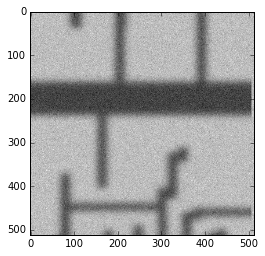

In [21]:
plt.imshow(im_np0, cm.gray)

Let's do the same for the second image:

In [23]:
input_image0 = os.path.join(TubeTK_BUILD_DIR, 'MIDAS_Data/ES0015_Large_Wo_offset.mha')
print("Image file path:%s"%input_image0)
reader1 = itk.ImageFileReader.New(FileName=input_image0)
reader1.Update()
im1=reader1.GetOutput()
print im1.GetOrigin()
print im1.GetSpacing()
print im1.GetDirection()

Image file path:/home/fbudin/Devel/TubeTK-Slicer-Release/TubeTK-build/MIDAS_Data/ES0015_Large_Wo_offset.mha
itkPointD2 ([0, 0])
itkVectorD2 ([1, 1])
<itkMatrixPython.itkMatrixD22; proxy of <Swig Object of type 'itkMatrixD22 *' at 0x7f759b1c9d20> >


itkImageFileReaderIF2: 0.000000itkImageFileReaderIF2: 1.000000

In [24]:
im_np1 = itk.PyBuffer[ImageType].GetArrayFromImage(im1)

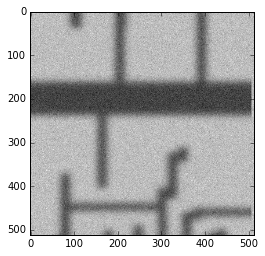

In [25]:
plt.imshow(im_np1, cm.gray)

Let's check if the spacing and direction are compatible:

In [26]:
im0.GetSpacing() == im1.GetSpacing() and im0.GetDirection() == im1.GetDirection()

True

We see that `im0` and `im1` are in fact compatible, but the origin of `im0` is at (200, 200).

## Merging - Example 1

In this example, we just want to merge our two images (**without registration**). Let's build the command-line arguments (The output image will be written to `/tmp/merged.mha`).

In [27]:
output_image = os.path.join(TubeTK_BUILD_DIR, 'Temporary/Python.MergeAdjacentImages-Ex1.mha')

cmd = [os.path.join(TubeTK_BUILD_DIR, 'bin/MergeAdjacentImages'),
       '-i 0', # Number of iterations ... here i=0, which means no registration,
       input_image0, # First image to merge
       input_image1, # Second image to merge
       output_image
      ]

Let's execute that command (via the `subprocess` module):

In [28]:
import subprocess
subprocess.call(cmd)

0

... and check if the output image `/tmp/merged.mha` was actually written to disk:

In [29]:
print os.path.exists(output_image)

True


We are now ready to visualize the result:

In [32]:
output_reader = itk.ImageFileReader.New(FileName=output_image)
output_reader.Update()
out_im=output_reader.GetOutput()
print out_im.GetOrigin()
print out_im.GetSpacing()
print out_im.GetLargestPossibleRegion().GetSize()

itkPointD2 ([0, 0])
itkVectorD2 ([1, 1])
itkSize2 ([712, 712])


itkImageFileReaderIF2: 0.000000itkImageFileReaderIF2: 1.000000

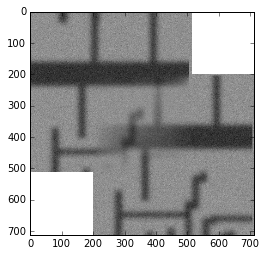

In [33]:
plt.imshow(itk.PyBuffer[ImageType].GetArrayFromImage(out_im), cm.gray)

We see that the output image is larger by 212 pixel in both dimensions, since the second image's origin was at (200, 200) and the
image size of both images was 512 times 512 pixel.

## Merging - Example 2

We can also add some padding (e.g., 50 pixel on each side). For that we modify `cmd` as follows:

In [34]:
output_image = os.path.join(TubeTK_BUILD_DIR, 'Temporary/Python.MergeAdjacentImages-Ex2.mha')

cmd = [os.path.join(TubeTK_BUILD_DIR, 'bin/MergeAdjacentImages'),
       '-i 0', # Number of iterations ... here i=0, which means no registration,
       '-b 50,50', # This adds a white border around the second image (50 pixel each side)
       input_image0,
       input_image1,
       output_image
      ]

In [35]:
subprocess.call(cmd)

0

itkImageFileReaderIF2: 0.000000itkImageFileReaderIF2: 1.000000

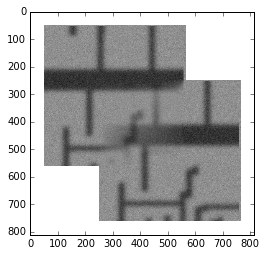

In [36]:
reader=itk.ImageFileReader.New(FileName=output_image)
reader.Update()
plt.imshow(itk.PyBuffer[ImageType].GetArrayFromImage(reader.GetOutput()), cm.gray)

## Merging - Example 3

Let's do the same example **WITH** rigid registration.

In [37]:
output_image = os.path.join(TubeTK_BUILD_DIR, 'Temporary/Python.MergeAdjacentImages-Ex3.mha')

cmd = [os.path.join(TubeTK_BUILD_DIR, 'bin/MergeAdjacentImages'),
       input_image1,
       input_image0,
       output_image
      ]

In [38]:
subprocess.call(cmd)

0

itkImageFileReaderIF2: 0.000000itkImageFileReaderIF2: 1.000000

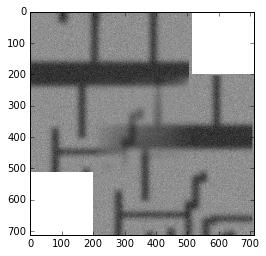

In [39]:
reader=itk.ImageFileReader.New(FileName=output_image)
reader.Update()
plt.imshow(itk.PyBuffer[ImageType].GetArrayFromImage(reader.GetOutput()), cm.gray)